# ABC Demand prediction

https://www.notion.so/Data-Scientist-Assessment-Test-adaf28bc80fc43aebf33af63b6a8a454

Esteban Betancur V

June 21-23 2021

# Data Loading

In [60]:
# Import basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#import datetime

In [61]:
# Load the dataset
df = pd.read_csv('Datos_Prueba_DataScientist.csv', dtype={0:'str',1:'str',2:'category'},
                 parse_dates=['RequestTime'])
#print(df.info())
df.head()

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm


No missing values, very clean dataset :)

# EDA
Some visualizations to understand the data

Text(0.5, 1.0, 'Monthly Orders')

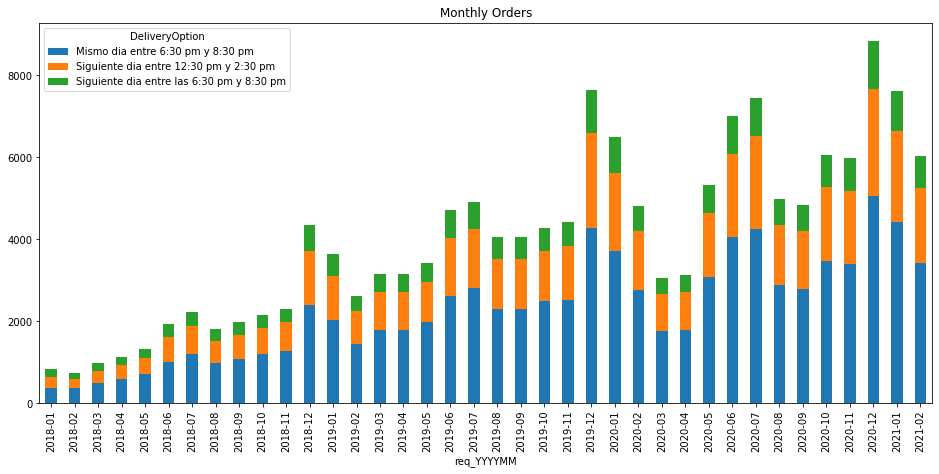

In [62]:
# Monthly orders
plt.rcParams["figure.figsize"] = (16,7)
df['req_YYYYMM'] = df['RequestTime'].dt.to_period('M')
df.groupby(['req_YYYYMM', 'DeliveryOption']).size().unstack().plot.bar(stacked=True)
plt.title("Monthly Orders")

A time growth on orders is evident, two special months are lower than expected (march and april, 2020) might be because of the covid affectedness. Also perodical peaks on december, january, june and july are seen, may be caused by vacation and legal extra salaries. Regarding the delivery option, almost half of the requests are made for the same day, and this proportion seems constant over time

Index(['Mismo dia entre 6:30 pm y 8:30 pm',
       'Siguiente dia entre 12:30 pm y 2:30 pm',
       'Siguiente dia entre las 6:30 pm y 8:30 pm'],
      dtype='object')


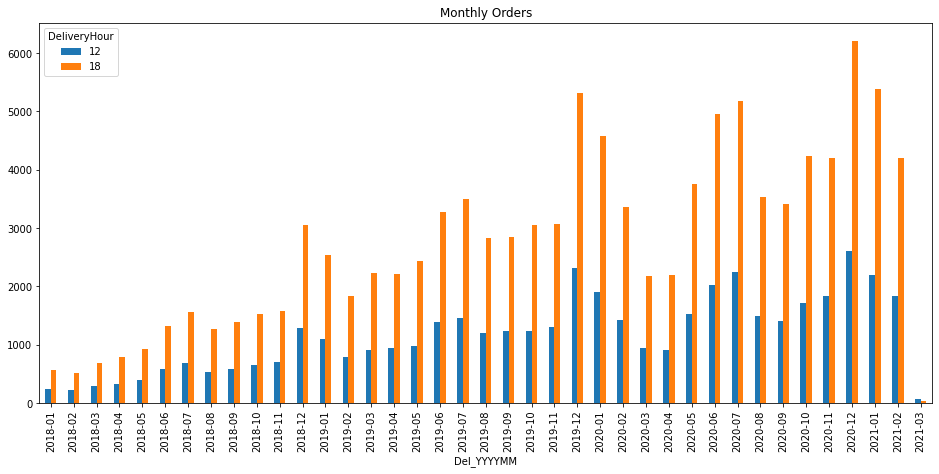

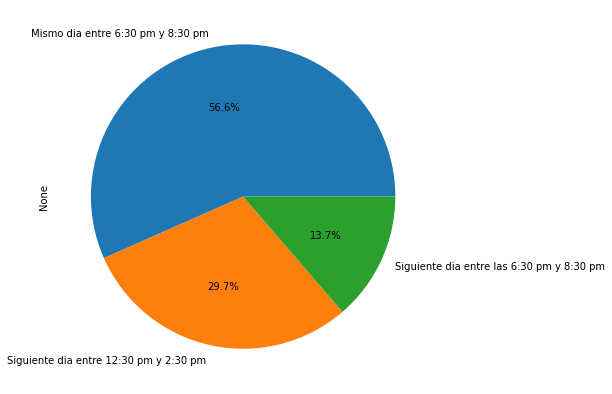

In [63]:
# New Variable of interest: Delivery schedule
# If delivery option1: Delivery sechedule is same day at 6:30pm
# If delivery option2: Delivery sechedule is next day at 12:30pm
# If delivery option3: Delivery schedule is next day at 6:30pm
cats = df['DeliveryOption'].cat.categories
print(cats)
hours = [18, 36, 42]
df["Delivery"] = df['RequestTime']

for cat, delta in zip(cats,hours):
  df.loc[df['DeliveryOption']==cat, "Delivery"] = (
    df.loc[df['DeliveryOption']==cat,'RequestTime'].dt.date + pd.DateOffset(hours=delta, minutes=30))
  
# Plot for the deliveries
df['DeliveryHour'] = df['Delivery'].dt.hour
df['Del_YYYYMM'] = df['Delivery'].dt.to_period('M')
df.groupby(['Del_YYYYMM', 'DeliveryHour']).size().unstack().plot.bar(stacked=False)
plt.title("Monthly Orders")

plt.figure()
df.groupby(['DeliveryOption']).size().plot.pie(autopct='%1.1f%%')

A majority of the orders is delivered at 18h, this is composed by option1 and option3 orders.  

historically, 70% of the orders are delivered at 6:30pm: 57% with option 1 (known the same day and enlisted in the afternoon shift) and 14% with option 3 (known the day before and enlisted in the morning shift). 

Regarding the 12:30 deliveries, they represent the 30% of the total and are known the day before. these orders should also be enlisted on the morning shift to meet the same day eniting condition. 

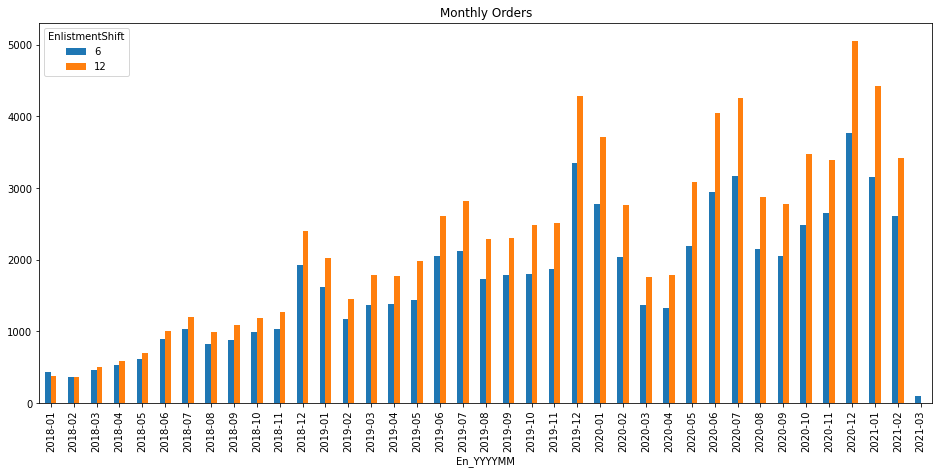

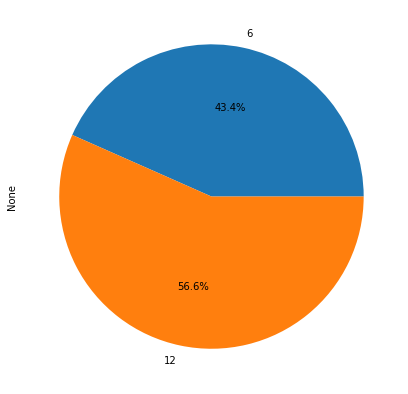

In [64]:
# Other Variable of interest: Enlistment shift
# If delivery option1: enlistment shift is same day afternoon
# If delivery option2: enlistment shift is next day morning
# If delivery option3: enlistment shift is next day morning
cats = df['DeliveryOption'].cat.categories
hours = [12, 30, 30]
df["Enlistment"] = df['RequestTime']

for cat, delta in zip(cats,hours):
  df.loc[df['DeliveryOption']==cat, "Enlistment"] = (
    df.loc[df['DeliveryOption']==cat,'RequestTime'].dt.date + pd.DateOffset(hours=delta))
  
df['EnlistmentShift'] = df["Enlistment"].dt.hour
df['En_YYYYMM'] = df["Enlistment"].dt.to_period('M')
df.groupby(['En_YYYYMM', 'EnlistmentShift']).size().unstack().plot.bar(stacked=False)
plt.title("Monthly Orders")

plt.figure()
df.groupby(['EnlistmentShift']).size().plot.pie(autopct='%1.1f%%')

Regarding the enlistment shift, a more balanced situation is evidenced, globally the 57% is enlisted during the 12-6 shift, while the 43% is enlisted during the 6-12 shift

Text(0, 0.5, 'Number of Orders')

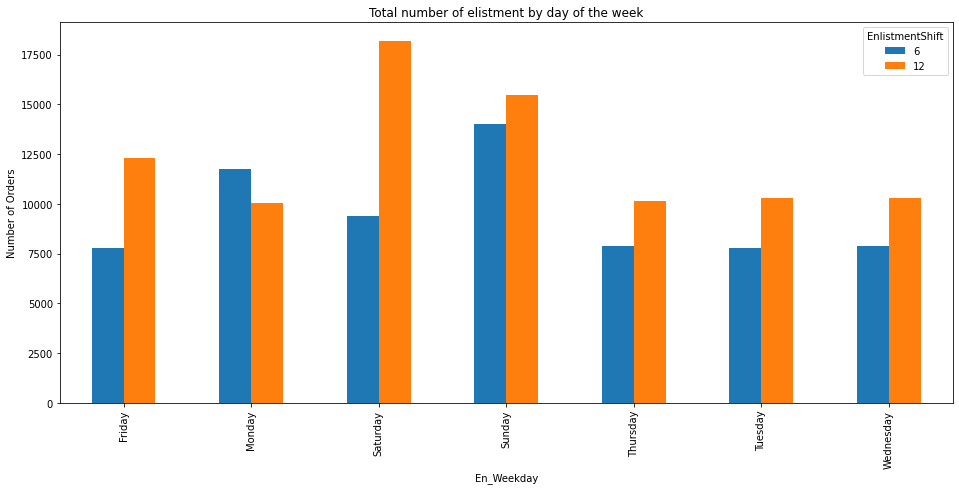

In [65]:
# Accumulated orders according to the day of the week
df['En_Weekday'] = df["Enlistment"].dt.day_name()
ax = df.groupby(['En_Weekday', 'EnlistmentShift']).size().unstack().plot.bar(stacked=False)
plt.title("Total number of elistment by day of the week")
plt.ylabel('Number of Orders')

Saturdays and Sundays present higher enlistment demands, almost all the weekdays the afteroon shift demand is higher except for Mondays. This because the high number of calls on sundays. Very important finding because the pickers allocation may be affected by this daily variation

Text(0.5, 1.0, 'Total number of calls by hour')

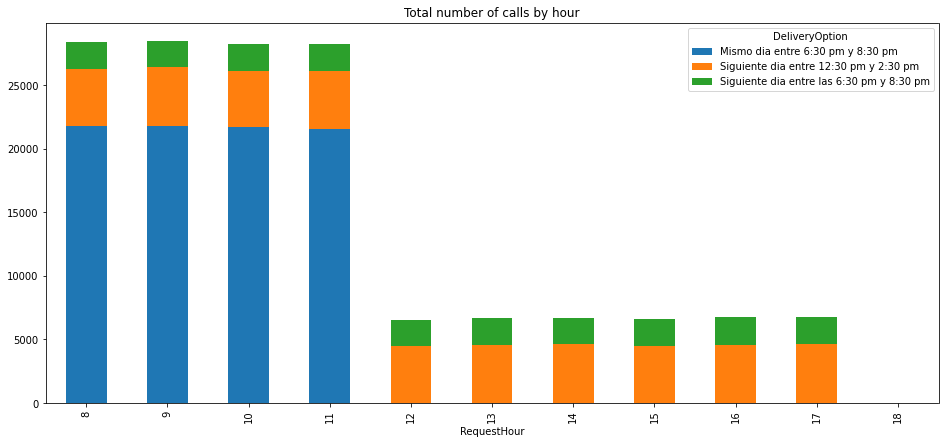

In [66]:
# Accumulated hourly calls
df['RequestHour'] = df['RequestTime'].dt.hour
#ax = df.groupby(df['RequestHour']).size().plot.bar()
ax = df.groupby(['RequestHour', 'DeliveryOption']).size().unstack().plot.bar(stacked=True)
plt.title("Total number of calls by hour")
#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

A GREAT portion of the calls is made on morning hours (During shift 1), although they have only 4 hours for calls, they receive around 3/4 of the total calls. Strange homegeneous distribution over the day 🤔

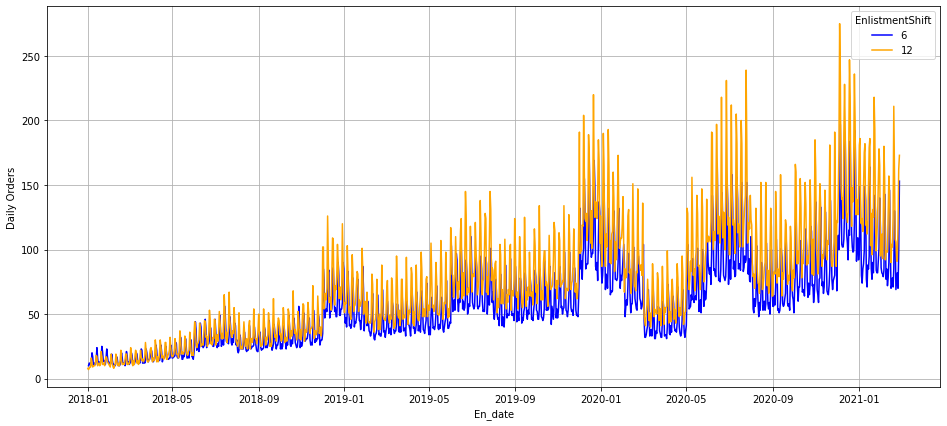

In [67]:
# New Dataframe with the number of orders per day and enlistment shift
df['En_date'] = df['Enlistment'].dt.date
df_day_en = df.groupby(['En_date', 'EnlistmentShift']).size().reset_index()
df_day_en.rename(columns={0: 'Orders'}, inplace=True)
df_day_en = df_day_en[:-1]  # REmove last row that correspond to march 1 morning enlistments

# Plot daily orders for both enlistment shifts
line=sns.lineplot(x="En_date", y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_day_en)
plt.ylabel('Daily Orders')
plt.grid()

Orders for afternoon shift remain higher during all the history of the data, inter-weekly variations are noticed with high variance on last months

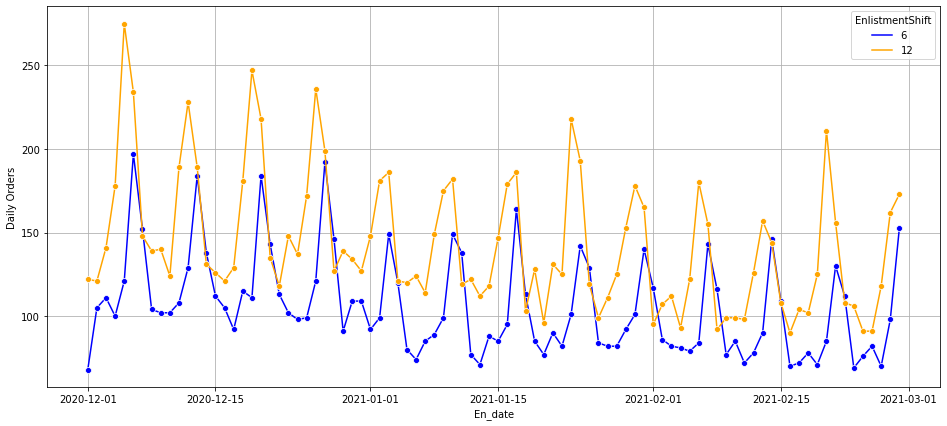

In [68]:
# Last 3 months
line=sns.lineplot(x="En_date", y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_day_en[-180:], marker='o')
plt.ylabel('Daily Orders')
plt.grid()

A peak is evidenced for saturdays afternoon and Sunday morning number of orders according to the last three month data

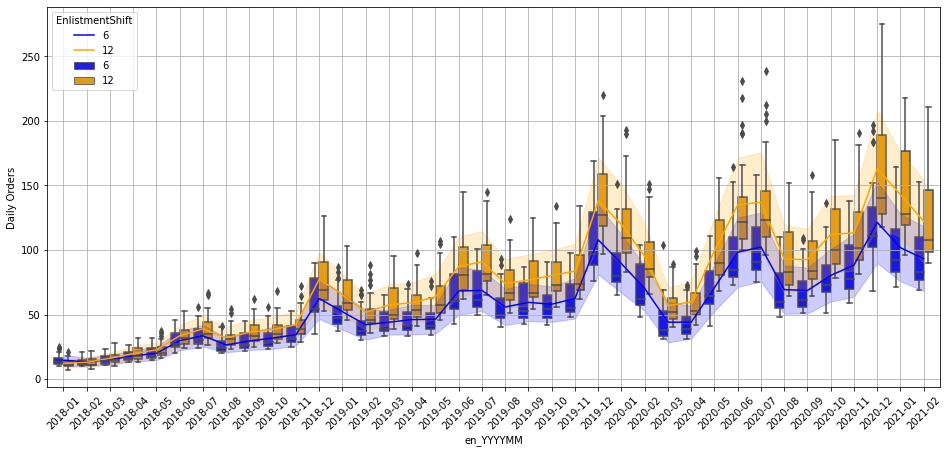

In [69]:
# Grouping by month
df_day_en['en_YYYYMM'] = pd.to_datetime(df_day_en['En_date']).dt.to_period('M')
sns.boxplot(x='en_YYYYMM', y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_day_en)
plt.xticks(rotation=45);
df_day_en['Month'] = df_day_en['en_YYYYMM'].astype('string')
sns.lineplot(x='Month', y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_day_en, ci='sd')
plt.ylabel('Daily Orders');
plt.grid()

In this figure, the lineplot shows the mean value for every month and the confidence interval based on the standard deviation with the shadows, while the boxplots display the median, interquartile range and limits. It is evidenced that the mean values are higher than the median what indicates right skewness of the daily orders when grouped by month. For every month, the company should define their bet using this information in order to guarantee enough pickers for the majority of the days.

If the picker selection is based on the mean+1sd, it is guaranteed that the orders are covered more than the 75% of the days, meaning that possibly some saturdays and sundays there would be not enough pickers. 

On the other hand, using 2sd above the mean or 1.5IQR above the median would guarantee the total coverage of the demand but having oversized the pickers for the majority of the days. THIS IS THE REQUIREMENT (Fulfillment of customer orders cannot be affected.)

Data from 2020-11 and Elistment shift 6 seems normally distributed: False, p:0.0934
Data from 2020-11 and Elistment shift 12 seems normally distributed: True, p:0.0165
Data from 2020-12 and Elistment shift 6 seems normally distributed: True, p:0.017
Data from 2020-12 and Elistment shift 12 seems normally distributed: False, p:0.0681
Data from 2021-01 and Elistment shift 6 seems normally distributed: False, p:0.0681
Data from 2021-01 and Elistment shift 12 seems normally distributed: False, p:0.1798
Data from 2021-02 and Elistment shift 6 seems normally distributed: True, p:0.0308
Data from 2021-02 and Elistment shift 12 seems normally distributed: True, p:0.0337


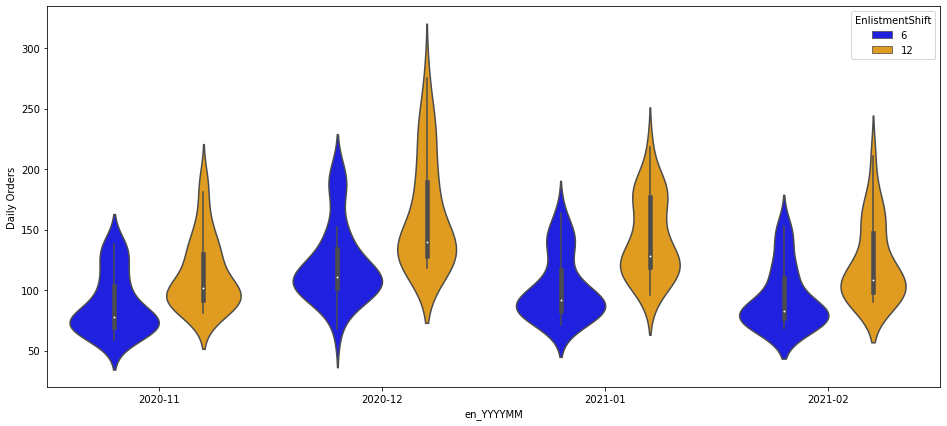

In [70]:
# Normality assesment: Taking the last 4 months a normality test is done 
# in order to validate if the number of shifth orders grouped by month presents
# a normal distribution

sns.violinplot(x='en_YYYYMM', y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_day_en[-240:])
plt.ylabel('Daily Orders');

from scipy import stats
months = ['2020-11', '2020-12', '2021-01', '2021-02']
alpha = 0.05
for m in months:
  for en in [6,12]:
    data = df_day_en[(df_day_en['Month']==m) & (df_day_en['EnlistmentShift']==en)]['Orders']
    k2, p = stats.normaltest(data)
    normal = p<alpha
    print(f"Data from {m} and Elistment shift {en} seems normally distributed: {normal}, p:{round(p,4)}")

The daily orders grouped by month are not always normally distributed, it can be seen a bimodal distribution that may be caused by the difference between orders in weekdays and weekends. Therefore, no assumptions of probability using normal distributions should be blindly trusted. Given this daily variation, the forecast model model is proposed on the Day granularity, to capture weekdays and weekeds separately and make decision accordingly.

# Orders forecasting

To predict the distribution of orders during march 2021, the daily dataframe with both shifts is used. Note that two lines per day are present, this given the two shifts per day (6 and 12)

In [71]:
df_day_en

,En_date,EnlistmentShift,Orders,en_YYYYMM,Month
0,2018-01-01,12,8,2018-01,2018-01
1,2018-01-02,6,10,2018-01,2018-01
2,2018-01-02,12,7,2018-01,2018-01
3,2018-01-03,6,12,2018-01,2018-01
4,2018-01-03,12,8,2018-01,2018-01
...,...,...,...,...,...
2304,2021-02-26,12,118,2021-02,2021-02
2305,2021-02-27,6,98,2021-02,2021-02
2306,2021-02-27,12,162,2021-02,2021-02
2307,2021-02-28,6,153,2021-02,2021-02


In [72]:
# A new dataframe is created for prediction purposes
df_pred = df_day_en[['En_date',	'EnlistmentShift',	'Orders']].copy()
df_pred['En_date'] = pd.to_datetime(df_pred['En_date'])

# Features for prediction
df_pred['Month'] = df_pred['En_date'].dt.month
df_pred['Year'] = df_pred['En_date'].dt.year
df_pred['dayofyear'] = df_pred['En_date'].dt.dayofyear
df_pred['dayofmonth'] = df_pred['En_date'].dt.day
df_pred['dayofweek'] = df_pred['En_date'].dt.dayofweek
df_pred['weekofyear'] = df_pred['En_date'].dt.isocalendar().week
# Days since first available data (numerical variable)
basedate = pd.Timestamp('2018-01-01')
df_pred['dayssince2008'] = df_pred.apply(lambda x: (x.En_date - basedate).days, axis=1)


# Other features from previous months are used to predict the actual month:
# average orders for both enlistments on last month
df_month6 = df_day_en[df_day_en['EnlistmentShift']==6][['Orders','en_YYYYMM']].groupby(['en_YYYYMM']).mean()
df_month12 = df_day_en[df_day_en['EnlistmentShift']==12][['Orders','en_YYYYMM']].groupby(['en_YYYYMM']).mean()
df_month6['prev_month_avg6'] = df_month6['Orders'].shift(periods=1) 
df_month12['prev_month_avg12'] = df_month12['Orders'].shift(periods=1) 

# Other features from previous months: max orders for both enlistments on last month
df_month6_max = df_day_en[df_day_en['EnlistmentShift']==6][['Orders','en_YYYYMM']].groupby(['en_YYYYMM']).max()
df_month12_max = df_day_en[df_day_en['EnlistmentShift']==12][['Orders','en_YYYYMM']].groupby(['en_YYYYMM']).max()
df_month6_max['prev_month_max6'] = df_month6_max['Orders'].shift(periods=1) 
df_month12_max['prev_month_max12'] = df_month12_max['Orders'].shift(periods=1) 

# Covid factor
df_month6['Covid_factor'] = 0
covid_months = [3,3,1,1,1,2,2,1,1,2,2,1]
df_month6.iloc[-12:, 2] = covid_months

# Merging month data into daily df
df_pred['en_YYYYMM'] = df_pred['En_date'].dt.to_period('M')
df_pred = pd.merge(df_pred, df_month6[['prev_month_avg6', 'Covid_factor']], 
                   on='en_YYYYMM', how='left')
df_pred = pd.merge(df_pred, df_month12['prev_month_avg12'], on='en_YYYYMM', how='left')
df_pred = pd.merge(df_pred, df_month6_max['prev_month_max6'], on='en_YYYYMM', how='left')

df_pred = pd.merge(df_pred, df_month12_max['prev_month_max12'], on='en_YYYYMM', how='left')

# Drop first month, no data for previous average :/
df_pred = df_pred[df_pred['en_YYYYMM']!= '2018-01']

df_pred.reset_index(inplace=True)

# Date column for plotting the results
df_pred['DateHH'] = df_pred['En_date']

df_pred.loc[df_pred['EnlistmentShift']==6, 'DateHH'] = (
    df_pred.loc[df_pred['EnlistmentShift']==6, 'DateHH'].dt.date + pd.DateOffset(hours=6))

df_pred.loc[df_pred['EnlistmentShift']==12, 'DateHH'] = (
    df_pred.loc[df_pred['EnlistmentShift']==12, 'DateHH'].dt.date + pd.DateOffset(hours=12))

data_dates = df_pred['DateHH']

# Drop non usable features for prediction model
df_pred.drop(columns=['En_date', 'en_YYYYMM', 'DateHH'], inplace=True)

Text(0.5, 1.0, 'Correlation Matrix')

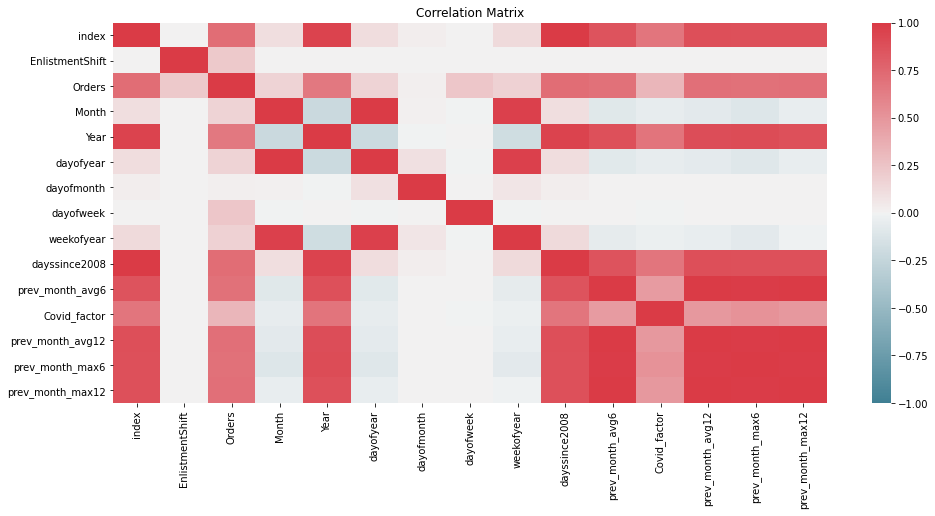

In [73]:
# Testing correlation between features and output varible (Orders)
corr_mat = df_pred.corr()
sns.heatmap(corr_mat,cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1, vmax=1)
plt.title("Correlation Matrix")

According to the correlation matrix, weekofyear, year, previous month avg6 and previous month avg 12 are removed as they are highly correlated with other remaining variables. The more important features seem to be previous month values and year

In [74]:
# Selection of the variables to use, classified by numerical and categorical
num_vars = ['dayssince2008', 'dayofyear', 'dayofmonth',
       'prev_month_avg12', 'prev_month_max12']
cat_vars = ['EnlistmentShift', 'Month', 'dayofweek', 'Covid_factor']

y = df_pred['Orders'].values
X_num = df_pred[num_vars].values.astype('float')
X_cat = df_pred[cat_vars].astype('category')
print(len(num_vars),len(cat_vars))
print(X_num.shape,X_cat.shape, y.shape)

5 4
(2248, 5) (2248, 4) (2248,)


In [75]:
# Description of the used variables for extra information saved on xlsx file
df_pred = df_pred[[*num_vars,*cat_vars,'Orders']]
df_pred.describe(include='all').T.to_excel('df_final_variables.xlsx')

In [76]:
# Onehotencoding is used to create dummy variables for categories
# 21 binary columns resulting from the 4 categorical variables
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop='first')
X_cat_enc = enc.fit_transform(X_cat).toarray()
print(enc.categories_)
print(X_cat_enc.shape)

# Scale the numaerical variables to the 0-1 range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_num_norm = scaler.fit_transform(X_num)

# Join the final variables, 26 resulting columns for prediction
X = np.append(X_num_norm, X_cat_enc, axis=1)
print(X.shape)

# Split data into train and test for selecting the model
# The first 32 months (84%) will be used for train and the last 6 months (16%) for test
split_row = 1886
X_train = X[:split_row]
y_train = y[:split_row]
X_test = X[split_row:]
y_test = y[split_row:]

[array([ 6, 12]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3])]
(2248, 21)
(2248, 26)


## Error Metrics and Plotting functions

Selected error metric: RMSE
This because RMSE gives more importance to big errors, and a big error on the prediction may lead to bad decision on the picker assignment.

In [77]:
from sklearn.metrics import mean_squared_error as mse

In [78]:
# Function to plot results
def plot_pred(y_train, y_test, pred_train, pred_test, data_dates, split_row, 
              name=''):
  
  rmse_train = round(mse(y_train, pred_train, squared=False), 3)
  rmse_test = round(mse(y_test, pred_test, squared=False), 3)

  fig = plt.figure()
  ax = fig.add_subplot()
  fig.subplots_adjust(top=1)

  plt.plot(data_dates[:split_row], y_train, 'b')
  plt.plot(data_dates[:split_row], pred_train, color='orange')
  
  plt.plot(data_dates[split_row:], y_test, 'b:')
  plt.plot(data_dates[split_row:], pred_test, ':', color='orange')
  plt.legend(['Real', name])
  plt.title(f'Regression daily prediction {name}')

  plt.axvline(x=pd.Timestamp(data_dates[split_row]), ymin=0, ymax=300, color='gray')

  plt.ylim([0,280])
  plt.ylabel('Daily Orders for both shifts')

  ax.text(pd.Timestamp('2020-06-15'), 250, 'Train ←', fontsize=14, color='gray')
  ax.text(pd.Timestamp('2020-09-10'), 250, '→ Test', fontsize=14, color='gray')

  ax.text(pd.Timestamp('2020-01-01'), 10, f'Train RMSE: {rmse_train}', fontsize=14)
  ax.text(pd.Timestamp('2020-10-01'), 10, f'Test RMSE: {rmse_test}', fontsize=14)

In [79]:
# Function to plot test results
def plot_test(y_test, pred_test, data_dates, split_row, 
              name=''):

  fig = plt.figure()
  ax = fig.add_subplot()
  fig.subplots_adjust(top=1)
  
  plt.plot(data_dates[split_row:], y_test, 'b')
  plt.plot(data_dates[split_row:], pred_test, color='orange')
  plt.legend(['Real', name])
  plt.title(f'Regression daily prediction {name}: Test data')

  plt.ylim([40,280])
  plt.ylabel('Daily Orders for both shifts')

## Linear Regresion: Baseline model

As a first aproach, multivariate linear regresion is used. A reference baseline is obtained 

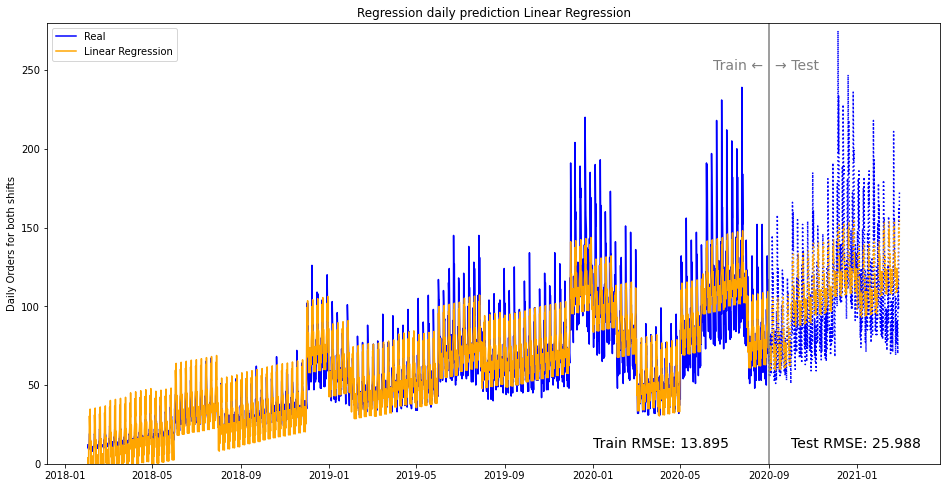

In [80]:
# Baseline model: Linear Regression
import statsmodels.api as sm

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
#print(res.summary())

plot_pred(y_train, y_test, res.predict(sm.add_constant(X_train)),
          res.predict(sm.add_constant(X_test)), data_dates, split_row,
          'Linear Regression')

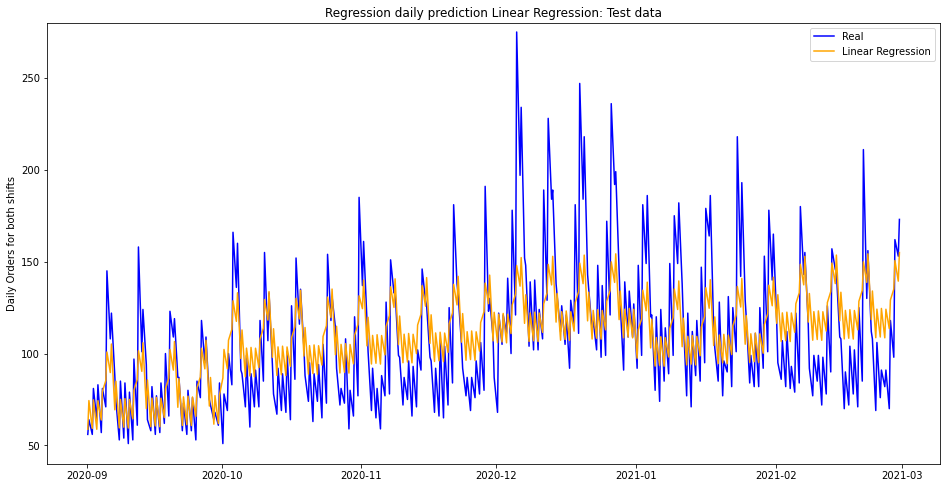

In [81]:
plot_test(y_test, res.predict(sm.add_constant(X_test)), data_dates, split_row,
          'Linear Regression')

According to the linear regression results, a good first approach is seen on the daily forecast. Nevertheless, the maximum peaks (that indeed define the pickers number for each shift) are not well captured. The RMSE of this model is 25.99

## Gradient Boosting Regressor: Proposed Model

For a better estiamtion, gradient boosting is proposed, this method is based on decision trees with adaptive building of the model in order to reduce prediction errors

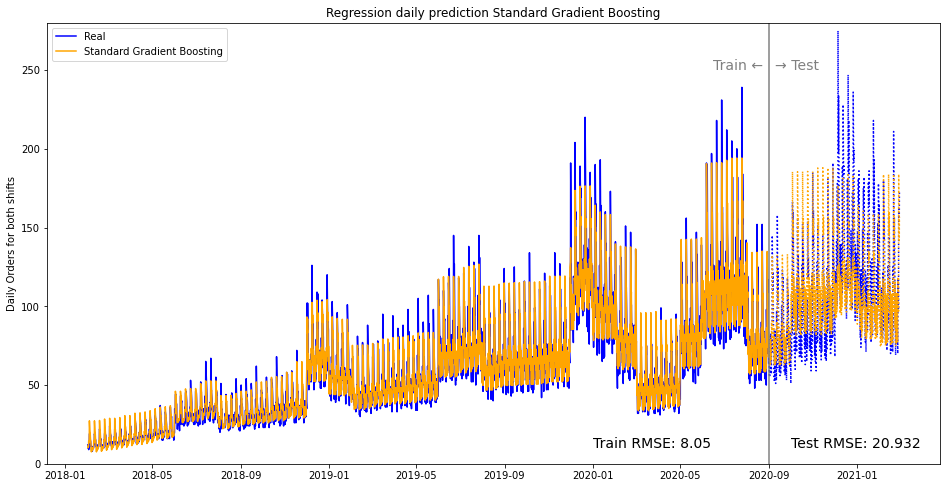

In [82]:
# Proposed model: Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
# Test 1: using default hyperparameters
reg1 = GradientBoostingRegressor()
reg1.fit(X_train,y_train)

plot_pred(y_train, y_test, reg1.predict(X_train), reg1.predict(X_test), 
          data_dates, split_row, 'Standard Gradient Boosting')

An inprovement with respect to the linear regression model is evidenced, the next step is tunning the model hyperparameters

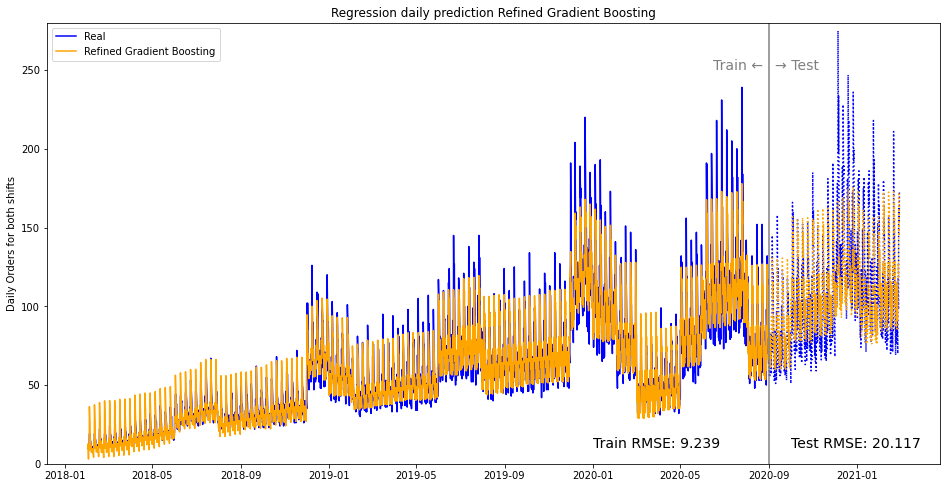

In [84]:
#Random search of hyperparameters using wide ranges

from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators':[30, 40, 100, 200, 300, 500],
 'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.4, 1], 'max_depth': [2,4,6,8,10],
 'min_samples_split':[2,3,4,6,8]}

search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist,
              cv=3, scoring='neg_mean_squared_error', n_jobs=8, n_iter = 150)

#search.fit(X_train, y_train)
search.best_params_ = {'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_split': 6,
 'n_estimators': 300}

# Refined model after the random search
reg2 = GradientBoostingRegressor(**search.best_params_)
reg2.fit(X_train,y_train)
plot_pred(y_train, y_test, reg2.predict(X_train), reg2.predict(X_test), 
          data_dates, split_row, 'Refined Gradient Boosting')

Not that much improvement when compared to first version of the model, nevertheless a reduction on the test RMSE is measured

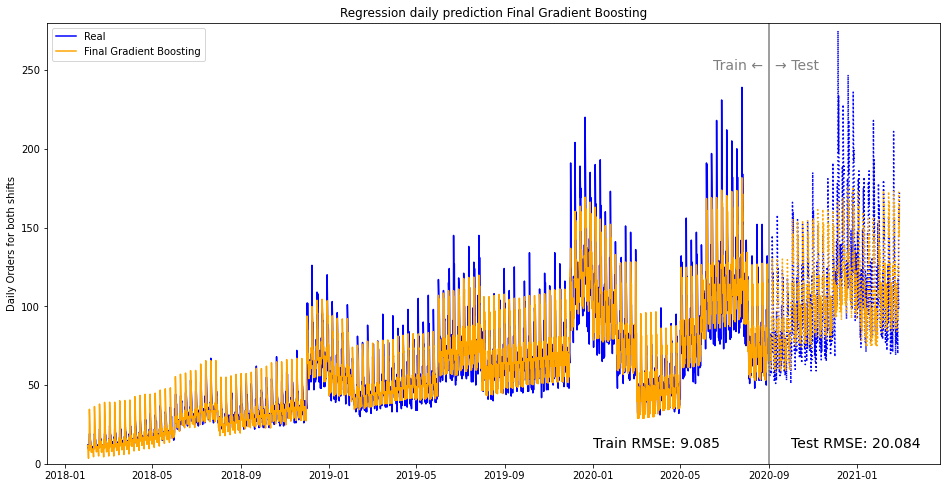

In [86]:
# Finally a local search of hiperramaters is done
param_dist = {
    'n_estimators':[250, 300, 350],
 'learning_rate':[0.05,0.1, 0.15], 'max_depth': [2,3],
 'min_samples_split':[5,6,7]}

from sklearn.model_selection import GridSearchCV
search2 = GridSearchCV(GradientBoostingRegressor(),param_grid=param_dist, 
                      cv=3, n_jobs=8, scoring='neg_mean_squared_error')

#search2.fit(X_train, y_train)
search2.best_params_ = {'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_split': 5,
 'n_estimators': 350}

reg3 = GradientBoostingRegressor(**search2.best_params_)
reg3.fit(X_train,y_train)
plot_pred(y_train, y_test, reg3.predict(X_train), reg3.predict(X_test), 
          data_dates, split_row, 'Final Gradient Boosting')

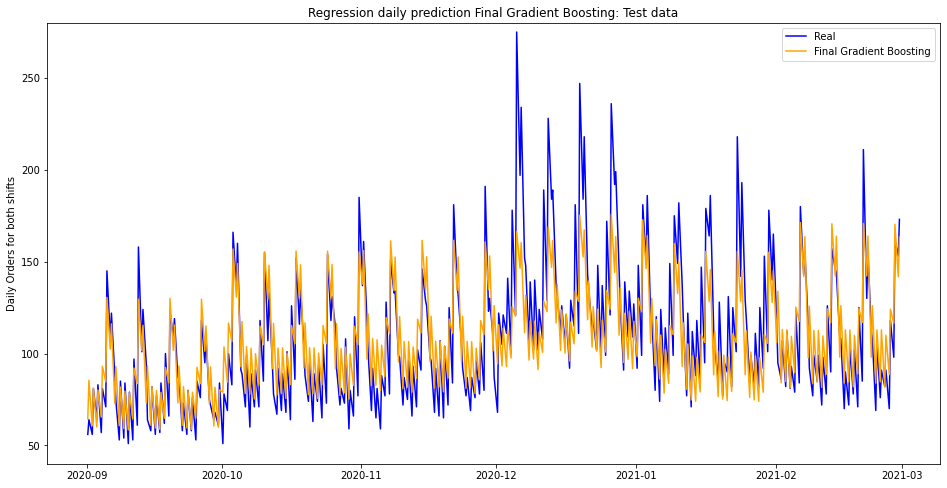

In [29]:
plot_test(y_test, reg3.predict(X_test), 
          data_dates, split_row, 'Final Gradient Boosting')

According to the plot, the model shows a good prediction of the daily orders. For December and January, the weekend peak values are not well predicted and this should be considered on these months planning. Finally, this model will be trained with all the data and used to predict march 2021 values.

## Final Deployment

In [87]:
# Final model using found hyperparameters
print(search2.best_params_)
reg_final = GradientBoostingRegressor(**search2.best_params_)
reg_final.fit(X,y)
round(mse(y, reg_final.predict(X), squared=False), 3)

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 5, 'n_estimators': 350}


9.863

As it was trained with the entire dataset, only training error is measured. 9.86 is the resulting RMSE

Text(0.5, 1.0, 'Model Forecast')

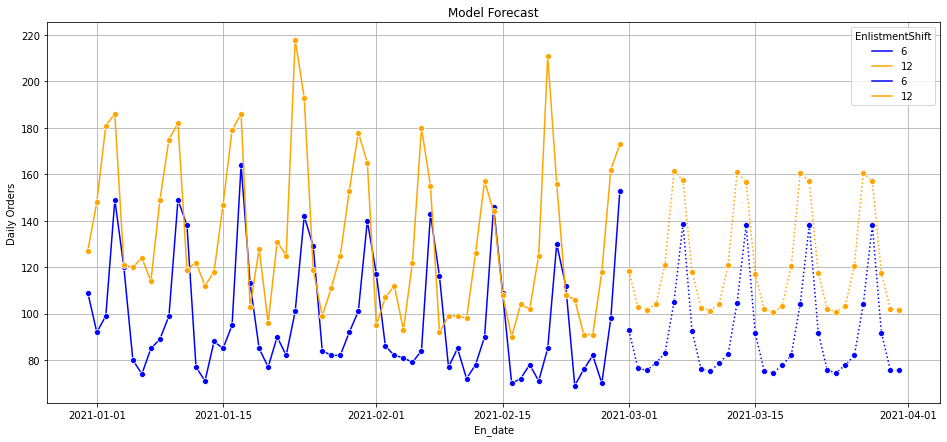

In [88]:
# Prepare March 2021 input features as done with the training data

df_march = df_pred[-62:].copy()
df_march['Covid_factor'] = 0
df_march.loc[:,'En_date'] = pd.date_range(start='2021/03/01', end='2021/04/01', periods=63)[:-1].date
df_march['En_date'] = pd.to_datetime(df_march['En_date'])

df_march['Month'] = df_march['En_date'].dt.month
df_march['dayofyear'] = df_march['En_date'].dt.dayofyear
df_march['dayofmonth'] = df_march['En_date'].dt.day
df_march['dayofweek'] = df_march['En_date'].dt.dayofweek

basedate = pd.Timestamp('2018-01-01')
df_march['dayssince2008'] = df_march.apply(lambda x: (x.En_date - basedate).days, axis=1)

df_march['prev_month_avg12'] = df_month12['Orders'][-1]
df_march['prev_month_max12'] = df_month12_max['Orders'][-1]

X_march_num = df_march[num_vars].values.astype('float')
X_march_cat = df_march[cat_vars].astype('category')

X_march_cat_enc = enc.transform(X_march_cat).toarray()
X_march_num_norm = scaler.transform(X_march_num)

X_march = np.append(X_march_num_norm, X_march_cat_enc, axis=1)

y_march = reg_final.predict(X_march)
df_march['Orders'] = y_march

line=sns.lineplot(x="En_date", y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_day_en[-120:], marker='o')
plt.ylabel('Daily Orders')
plt.grid()

line=sns.lineplot(x="En_date", y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_march, 
                  linestyle=':', marker='o')
plt.title('Model Forecast')

The march prediction is visually good, weekly patterns are followed and 4 homogeneous weeks are predicted. 

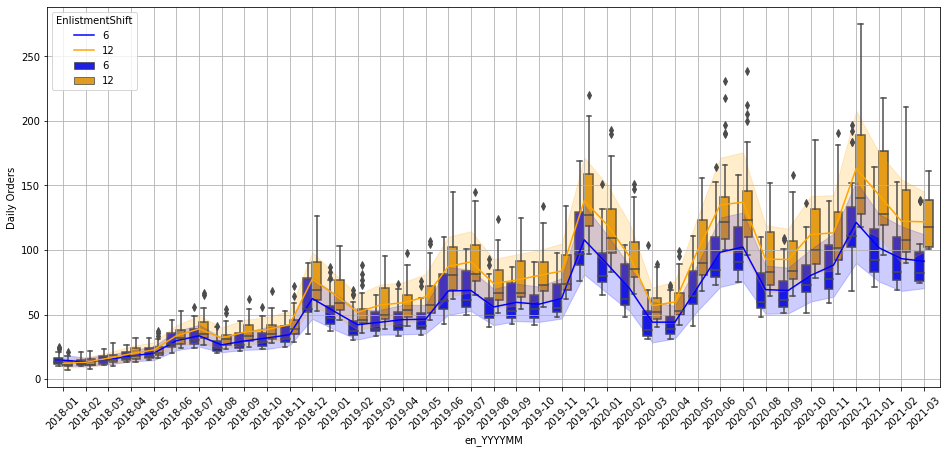

In [89]:
# Gropuing the results by month to see tendency
df_full =  pd.concat([df_day_en, df_march], axis=0)
df_full["En_date"] = pd.to_datetime(df_full["En_date"])
df_full['en_YYYYMM'] = df_full["En_date"].dt.to_period('M')
sns.boxplot(x='en_YYYYMM', y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_full)
plt.xticks(rotation=45);
df_full['Month'] = df_full['en_YYYYMM'].astype('string')
sns.lineplot(x='Month', y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_full, ci='sd')
plt.ylabel('Daily Orders');
plt.grid()

In this plot, the last 2 boxplots correspond to the predicted data, altlhough the monthly tendency is logic, the upper whiskers might be short and an outlier saturday can exceed this prediction.

# Pickers allocation
Following the indications, a fixed number of pickers may be defined for the 6-12 shift and other number for the 12-6 shift. This numbers will remain constant during the entire month

The number of pickers is calculated using the minimum work ratio per operator (5 orders per hour, or 30 orders per shift). And following that "Fulfillment of customer orders cannot be affected" this number is calculated using the maximum value per shift.

In [94]:
pickers_morning = np.ceil(df_march[df_march['EnlistmentShift']==6]['Orders'].max()/30)
pickers_morning

5.0

In [97]:
pickers_afternoon = np.ceil(df_march[df_march['EnlistmentShift']==12]['Orders'].max()/30)
pickers_afternoon

6.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f4f47c49c10> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f4f484232d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f4f6ed0dd10> has a label of '_nolegend_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f4f459618d0> has a label of '_nolegend_' which cannot be automatically added to the legend.


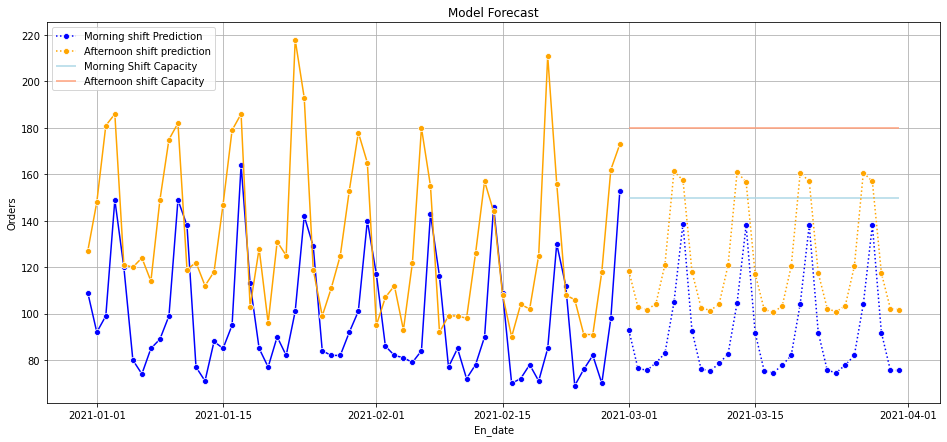

In [144]:
ax1 = sns.lineplot(x="En_date", y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_march, 
                  linestyle=':', marker='o')

ax3 = plt.hlines(pickers_morning*30, pd.Timestamp('2021-03-01'), 
           pd.Timestamp('2021-03-31'), colors="lightblue", label='Morning Shift Capacity')

ax4 = plt.hlines(pickers_afternoon*30, pd.Timestamp('2021-03-01'), 
           pd.Timestamp('2021-03-31'), colors="lightsalmon", label='Afternoon Shift Capacity')

ax2 = sns.lineplot(x="En_date", y="Orders", hue="EnlistmentShift",
                  palette=["blue", "orange"], data=df_day_en[-120:], marker='o', label='_nolegend_')

plt.title('Model Forecast')
plt.grid()
plt.legend(['Morning shift Prediction', 'Afternoon shift prediction',
            '_nolegend_', '_nolegend_','_nolegend_', '_nolegend_','Morning Shift Capacity', 'Afternoon shift Capacity'], loc=2);

This plot shows the March predicition and recommended allocated capacity of pickers (5 for the morning shift and 6 for the afternoon shift). As recommendtions, a felxible number of pickers should be used because during weekdays they will have an oversized picker number.

It is possible that on weekends the demand can exceed the capacity of pickers, but it is not recommended to hire more pickers for the entire month.
